# はじめに

# NUTS

2.99882646635 1.02180321215


/home/kei/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


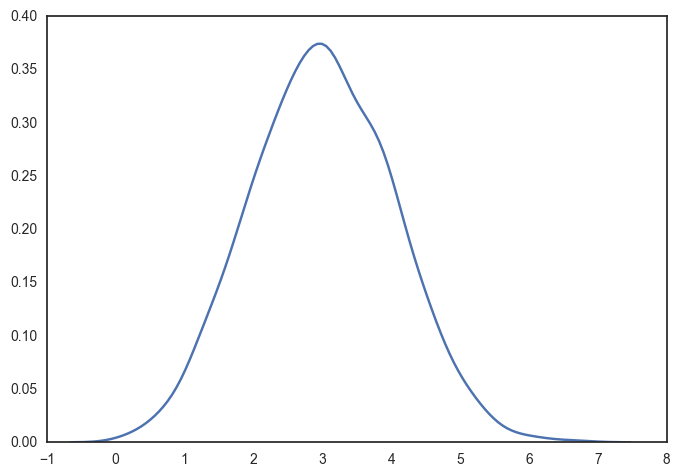

In [1]:
import numpy as np
from numpy import exp
from copy import deepcopy
import pylab as plt
import seaborn as sns
from scipy.stats import norm, gamma
from tqdm import tqdm
from numpy import random
from matplotlib.animation import FuncAnimation

sns.set_style("white")

true_μ = 3
true_σ = 1
nb_data = 1000

x = np.random.normal(true_μ, true_σ, nb_data)

print(x.mean(), x.std())
sns.kdeplot(x)
plt.show()

In [2]:
def log_dh(μ, σ):
    return np.array([-np.sum(x - μ) / σ**2,
                     len(x) / (2 * σ**2) - np.sum((x - μ)**2) / (2 * σ**4)])

def H(θₜ, p):
    return -norm_lpdf(θₜ[0], θₜ[1]) + 0.5 * np.dot(p, p)

def Leapfrog(x, θ, r, ε):
    θ_d = deepcopy(θ)
    r_d = deepcopy(r)
    r_d -= 0.5 * ε * log_dh(θ_d[0], θ_d[1])
    θ_d[0] = θ_d[0] + ε * r_d[0]
    θ_d[1] = θ_d[1] + ε * r_d[1]
    r_d -= 0.5 * ε * log_dh(θ_d[0], θ_d[1])
    return θ_d, r_d

In [3]:
norm_lpdf = lambda μ, σ: np.sum(norm.logpdf(x, μ, σ))
gamma_lpdf = lambda a: np.sum(gamma.logpdf(x, a))

Δ_max = 1000
ε = 0.05
L = norm_lpdf
M = 100

θ0 = np.array([random.randn(), random.gamma(1)])
list_θₘ = [θ0]

In [4]:
def BuildTree(θ, r, u, v, j, ε):
    if j == 0:
        θd, rd = Leapfrog(x, θ, r, v * ε)
        if np.log(u) <= (L(*θd) - 0.5 * np.dot(rd, rd)):
            Cd_ = [[θd, rd]]
        else:
            Cd_ = []
        sd = int(np.log(u) < (Δ_max + L(*θd) - 0.5 * np.dot(rd, rd)))
        return θd, rd, θd, rd, Cd_, sd
    else:
        θ_minus, r_minus, θ_plus, r_plus, Cd_, sd = BuildTree(θ, r, u, v, j - 1, ε)
        if v == -1:
            θ_minus, r_minus, _, _, Cdd_, sdd = BuildTree(θ_minus, r_minus, u, v, j - 1, ε)
        else:
            _, _, θ_plus, r_plus, Cdd_, sdd = BuildTree(θ_plus, r_plus, u, v, j - 1, ε)
        sd = sdd * sd * int((np.dot(θ_plus - θ_minus, r_minus) >= 0) and (np.dot(θ_plus - θ_minus, r_plus) >= 0))
        Cd_.extend(Cdd_)

        return θ_minus, r_minus, θ_plus, r_plus, Cd_, sd

In [5]:
hist_L = []
hist_C = []
for m in tqdm(range(M)):
    r0 = random.randn(2)
    u = random.uniform(0, exp(L(*list_θₘ[-1]) - 0.5 * np.dot(r0, r0)))

    θ_minus = deepcopy(list_θₘ[-1])
    θ_plus = deepcopy(list_θₘ[-1])
    r_minus = deepcopy(r0)
    r_plus = deepcopy(r0)
    j = 0
    C = [[deepcopy(list_θₘ[-1]), deepcopy(r0)]]
    s = 1

    while s == 1:
        v = random.choice([-1, 1])
        if v == -1:
            θ_minus, r_minus, _, _, Cd, sd = BuildTree(θ_minus, r_minus, u, v, j, ε)
        else:
            _, _, θ_plus, r_plus, Cd, sd = BuildTree(θ_plus, r_plus, u, v, j, ε)

        if sd == 1:
            C.extend(Cd)
        s = sd * int((np.dot(θ_plus - θ_minus, r_minus) >= 0) and (np.dot(θ_plus - θ_minus, r_plus) >= 0))
        j += 1

    index = random.choice(list(range(len(C))))
    list_θₘ.append(C[index][0])

    hist_L.append(L(C[index][0][0], C[index][0][1]))
    hist_C.append(C)

100%|██████████| 100/100 [00:00<00:00, 760.56it/s]


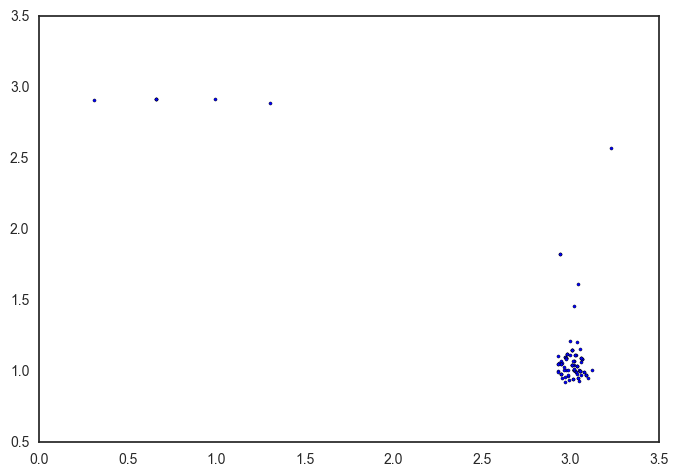

In [14]:

def plot(list_θₘ, hist_C):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    def update(i):
        fig.canvas.draw()
        ax.cla()
        j = i // 3
        if (i % 3) == 0:
            ax.scatter(np.array(hist_C[j])[:, 0, 0], np.array(hist_C[j])[:, 0, 1], linewidth=0, marker=".")
            ax.plot(list_θₘ[:(j), 0], list_θₘ[:(j), 1], c="gray", linewidth=0.3, alpha=0.4)
            ax.scatter(list_θₘ[:(j), 0], list_θₘ[:(j), 1], c="g", linewidth=0, marker=".")

        elif (i % 3) == 1:
            ax.scatter(np.array(hist_C[j])[:, 0, 0], np.array(hist_C[j])[:, 0, 1], linewidth=0, marker=".")
            ax.plot(list_θₘ[:(j + 1), 0], list_θₘ[:(j + 1), 1], c="gray", linewidth=0.3, alpha=0.4)
            ax.scatter(list_θₘ[:(j + 1), 0], list_θₘ[:(j + 1), 1], c="g", linewidth=0, marker=".")
        else:
            ax.scatter(np.array(hist_C[j])[:, 0, 0], np.array(hist_C[j])[:, 0, 1], linewidth=0, marker=".", c="w")
            ax.plot(list_θₘ[:(j + 1), 0], list_θₘ[:(j + 1), 1], c="gray", linewidth=0.3, alpha=0.4)
            ax.scatter(list_θₘ[:(j + 1), 0], list_θₘ[:(j + 1), 1], c="g", linewidth=0, marker=".")

        plot_lim = 30
        if(j) > plot_lim:
            temp_list = np.array([[np.min(np.array(C)[:, 0], axis=0),
                                   np.max(np.array(C)[:, 0], axis=0)] for C in hist_C[j - plot_lim: j]])

            temp_xlim = [np.min(temp_list[:, :, 0]), np.max(temp_list[:, :, 0])]
            xlim_range = temp_xlim[1] - temp_xlim[0]
            temp_ylim = [np.min(temp_list[:, :, 1]), np.max(temp_list[:, :, 1])]
            ylim_range = temp_ylim[1] - temp_ylim[0]
            plt.xlim(temp_xlim[0] - xlim_range * 0.1, temp_xlim[1] + xlim_range * 0.1)
            plt.ylim(temp_ylim[0] - ylim_range * 0.1, temp_ylim[1] + ylim_range * 0.1)

    ani = FuncAnimation(fig, update, frames=len(hist_C) * 3 - 2)
    ani.save("temp.gif", writer="imagemagick", fps=3)
    
plt.scatter(list_θₘ[:,0], list_θₘ[:,1], marker=".")
plt.show()
plot(list_θₘ, hist_C)